<a href="https://colab.research.google.com/github/wiwianaa/AnalizaSentymentu/blob/main/Lebiodzik_datalabelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Przygotowanie środowiska

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tweepy
#!pip install gensim

In [1]:
!python -m pip install spacy==2.3.2 -q
!python -m spacy download pl_core_news_lg # końcówka _lg oznacza rozmiar modelu, mamy jeszcze sm czyli small i md czyli medium

     |████████████████████████████████| 9.9 MB 4.4 MB/s 
     |████████████████████████████████| 2.1 MB 15.8 MB/s 
     |████████████████████████████████| 604.2 MB 1.2 MB/s 
  Created wheel for pl-core-news-lg: filename=pl_core_news_lg-2.3.0-py3-none-any.whl size=604232611 sha256=632689976a7bb22c82fc822b08985aa3c805596884b5efb4b7838873ea469a06
  Stored in directory: /tmp/pip-ephem-wheel-cache-hi7__pmd/wheels/54/f5/e7/0f8b228e57fe660f87d3ab03d4bbb71eb2f6fe3f5b426d477c
Successfully built pl-core-news-lg
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_lg')


In [1]:
#biblioteki
import tweepy
import pandas as pd
import spacy
import json
from scipy import spatial # biblioteka do obliczeń
from spacy import displacy # wizualizacja drzewa zaleznosci
# pomocnicze
import re
import numpy as np
import string
# wizualizacja
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# sklearn - modele do ML
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
#gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
# import potrzebnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

#nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# system
#import os
#import shutil

# tf
import tensorflow as tf

#filter warnings
import warnings
warnings.filterwarnings('ignore')

#karas
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Pobieranie danych

In [ ]:
#moje klucze tweetera
#%run ./drive/MyDrive/ZUM/my_keys.ipynb

In [ ]:
#autentykacja
#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_token_secret)
#api = tweepy.API(auth, wait_on_rate_limit=True)    # set wait_on_rate_limit =True; as twitter may block you from querying if it finds you exceeding some limits

In [ ]:
#cursor = tweepy.Cursor(api.search, q='klimatu', lang = 'pl', tweet_mode="extended").items(1)

In [ ]:
#for c in cursor:
#  text = c.full_text
#  print(text)

In [ ]:
#no_of_tweets = 2000
#tweets = []
#likes = []
#time = []

#my_list = ['ocieplenie', 'zmiana', 'zmiany', 'zmian', 'zmianie', 'zmianom', 'zmianę',	'zmianami', 'zmianach']
#string = ' klimatu'
#my_new_list = [x + string for x in my_list]
#my_list2 = ['globalne ocieplenie', 	'globalnego ocieplenia', 'globalnym ociepleniu', 'globalnym	ociepleniem']
#search_terms = my_list + my_list2

#for c in tweepy.Cursor(api.search, q=search_terms[12], lang = 'pl', tweet_mode="extended", since = '2022-01-15', until = '2022-01-17').items(no_of_tweets):
#  tweets.append(c.full_text)
#  likes.append(c.favorite_count)
#  time.append(c.created_at)

In [2]:
#df = pd.DataFrame({'tweets': tweets, 'likes' : likes, 'time' : time})
#df

In [5]:
#df = df[~df.tweets.str.contains("RT")] # w ten sposób możemy odfiltrować tweety spełniające podany w nawiasie warunek
#df['tweets'].drop_duplicates(keep="first", inplace=True)
#df = df.reset_index(drop=True) # krok, żeby zachować indeksy w dobrej kolejności, bez luk po usunięciu wierszy
#df.to_csv('/content/drive/MyDrive/ZUM/tweets_data.csv')
#df.to_csv('/content/drive/MyDrive/ZUM/tweets_data.csv', mode='a', header=False)
#df

In [104]:
data = pd.read_csv("/content/drive/MyDrive/ZUM/tweets_data.csv", encoding="utf-8") 
data = data[["tweets", "likes", "time"]]
data['tweets'].drop_duplicates(keep="first", inplace=True)
data = data[~data.tweets.str.contains("ocieplenie wizerunku")] # zagadnienia nie zgodne z tematem
#data['tweets'] = data['tweets'].str.encode("utf-8")
print(data.size)
data.head()

95943


,tweets,likes,time
0,@gazeta_Mocarski @ela_kam___ @copone1dak Jedno...,0,2022-01-15 11:41:23
2,💬Posłanka @Ula_Zielińska o #ZielonyOdbudowy: G...,6,2022-01-15 11:34:24
3,💬Globalne ocieplenie powoduje coraz częstsze i...,7,2022-01-15 11:24:55
4,❗️Małgorzata Tracz - dodał(a) tweeta.\n🗨️ Treś...,0,2022-01-15 11:09:12
5,💬 – Globalne ocieplenie powoduje coraz częstsz...,13,2022-01-15 11:09:07


Model labelling

In [105]:
#zaladowanie modelu spacy
import spacy
nlp = spacy.load('pl_core_news_lg') # zwyczajowo nazywamy zmienną do modelu nlp
stopwordlist = nlp.Defaults.stop_words

In [106]:
def clean_text(text):
  text = text.lower()
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
  text = re.sub('\$[a-zA-Z0-9_]*', ' ', text)
  text = re.sub('\@[AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpRrSsŚśTtUuWwYyZzŹźŻż0-9_]*', ' ', text)
  text = re.sub('[^[AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpRrSsŚśTtUuWwYyZzŹźŻż\']', ' ', text)
  text = re.sub('\t', '', text)
  text = re.sub('\n', ' ', text)
  text = [w for w in text.split() if len(w)>1]
  #text = " ".join([word for word in str(text).split() if word not in stopwordlist])
  return text

In [107]:
data['clean_tweet'] = data['tweets'].apply(clean_text)
data['cleaned_tweet'] = data['clean_tweet'].apply(lambda x:' '.join(x))
data.head()

,tweets,likes,time,clean_tweet,cleaned_tweet
0,@gazeta_Mocarski @ela_kam___ @copone1dak Jedno...,0,2022-01-15 11:41:23,"[jedno, mnie, zastanawia, wpływ, ludzkiego, co...",jedno mnie zastanawia wpływ ludzkiego co na oc...
2,💬Posłanka @Ula_Zielińska o #ZielonyOdbudowy: G...,6,2022-01-15 11:34:24,"[posłanka, zielonyodbudowy, globalne, ocieplen...",posłanka zielonyodbudowy globalne ocieplenie p...
3,💬Globalne ocieplenie powoduje coraz częstsze i...,7,2022-01-15 11:24:55,"[globalne, ocieplenie, powoduje, coraz, częsts...",globalne ocieplenie powoduje coraz częstsze co...
4,❗️Małgorzata Tracz - dodał(a) tweeta.\n🗨️ Treś...,0,2022-01-15 11:09:12,"[małgorzata, tracz, dodał, tweeta, treść, glob...",małgorzata tracz dodał tweeta treść globalne o...
5,💬 – Globalne ocieplenie powoduje coraz częstsz...,13,2022-01-15 11:09:07,"[globalne, ocieplenie, powoduje, coraz, częsts...",globalne ocieplenie powoduje coraz częstsze co...


In [108]:
#lematyzacja
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    tokens = nlp(data)
    tokens = [token.lemma_ for token in tokens]
    return tokens
data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x: lemmatizer_on_text(x))
data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x:' '.join(x))
data.head()

,tweets,likes,time,clean_tweet,cleaned_tweet
0,@gazeta_Mocarski @ela_kam___ @copone1dak Jedno...,0,2022-01-15 11:41:23,"[jedno, mnie, zastanawia, wpływ, ludzkiego, co...",jeden ja zastanawiać wpływ ludzki co na ociepl...
2,💬Posłanka @Ula_Zielińska o #ZielonyOdbudowy: G...,6,2022-01-15 11:34:24,"[posłanka, zielonyodbudowy, globalne, ocieplen...",posłanek zielonyodbudowy globalny ocieplenie p...
3,💬Globalne ocieplenie powoduje coraz częstsze i...,7,2022-01-15 11:24:55,"[globalne, ocieplenie, powoduje, coraz, częsts...",globalny ocieplenie powodować coraz częsty cor...
4,❗️Małgorzata Tracz - dodał(a) tweeta.\n🗨️ Treś...,0,2022-01-15 11:09:12,"[małgorzata, tracz, dodał, tweeta, treść, glob...",małgorzata tracz dodać tweet treść globalny oc...
5,💬 – Globalne ocieplenie powoduje coraz częstsz...,13,2022-01-15 11:09:07,"[globalne, ocieplenie, powoduje, coraz, częsts...",globalny ocieplenie powodować coraz częsty cor...


In [109]:
stopwordlist = nlp.Defaults.stop_words
def remove_stopwords(text):
  text = " ".join([word for word in str(text).split() if word not in stopwordlist])
  return text
data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_stopwords)
data = data.drop_duplicates(subset=['cleaned_tweet'], keep="first")
#data['clean_tweet'] = data['cleaned_tweet']
#data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x:' '.join(x))
data = data.drop(['time', 'likes', 'clean_tweet'], axis=1)
data.head()


,tweets,cleaned_tweet
0,@gazeta_Mocarski @ela_kam___ @copone1dak Jedno...,zastanawiać wpływ ludzki ocieplenie klimat udo...
2,💬Posłanka @Ula_Zielińska o #ZielonyOdbudowy: G...,posłanek zielonyodbudowy globalny ocieplenie p...
3,💬Globalne ocieplenie powoduje coraz częstsze i...,globalny ocieplenie powodować częsty długo trw...
4,❗️Małgorzata Tracz - dodał(a) tweeta.\n🗨️ Treś...,małgorzata tracz dodać tweet treść globalny oc...
5,💬 – Globalne ocieplenie powoduje coraz częstsz...,globalny ocieplenie powodować częsty długo trw...


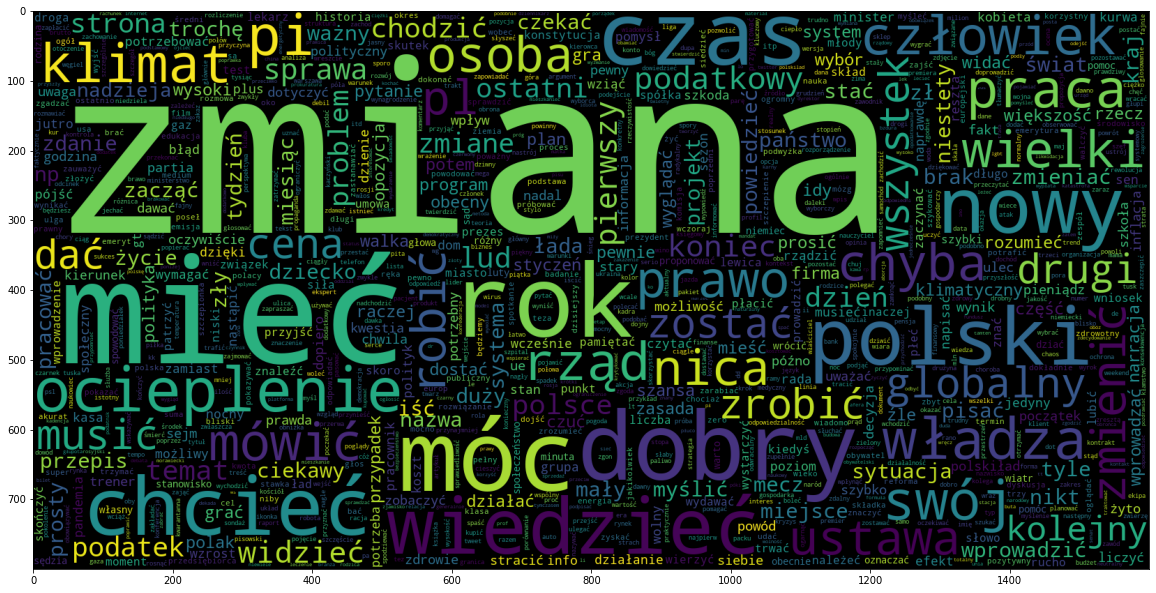

In [110]:
#najcześciej wystepujace slowa
#import matplotlib.pyplot as plt
#from wordcloud import WordCloud

#data_neg = ds['clean_tweet'].apply(lambda x:' '.join(x))
#data_neg = ds['text'][:800000]

#print(data_neg.head())

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data['cleaned_tweet']))
plt.imshow(wc)

In [111]:
data.to_csv('/content/drive/MyDrive/ZUM/tweets_cleaned.csv')

In [112]:
#data = pd.read_csv("/content/drive/MyDrive/ZUM/tweets_cleaned.csv")
#print(data.dtypes)
#data

In [113]:
X=data['cleaned_tweet']
X = X.apply(lambda x:x.split())
X.dtypes

dtype('O')

In [114]:
sent = [row for row in X]

phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [115]:
sentences[1]

['posłanek',
 'zielonyodbudowy_globalny',
 'ocieplenie_powodować',
 'częsty_długo',
 'trwać_ekstremum',
 'pogodowy_gwałtowny',
 'ulewa_fał',
 'upał_susza',
 'zjawisko_dotykać',
 'wszystek_region',
 'świat_zielonyplanodbudowy',
 'zielonimająplan_kongreszielonych']

In [61]:
from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50).fit(tweets)

word to vec

In [116]:
# inicjalizacja modelu word2vec

import multiprocessing

w2v_model = Word2Vec(min_count=4,
                     window=5,
                     size =300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)

#print(w2v_model)
w2v_model.build_vocab(sentences, progress_per=50000)

In [69]:
#word2vec_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/ZUM/nkjp.txt', binary=False)
#embedding_matrix = word2vec_model.wv.syn0
#word2vec_model.wv.most_similar(positive=["pozytywny"])

In [117]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.wv.most_similar(positive=["potrzebny"])

[('krytykować', 0.999920129776001),
 ('uważać', 0.9999188780784607),
 ('jk', 0.9999182224273682),
 ('własny_skóra', 0.9999178647994995),
 ('będziecie', 0.99991774559021),
 ('wiatr_wielki', 0.999916672706604),
 ('boostera', 0.999916672706604),
 ('zachodzić', 0.9999165534973145),
 ('jeść_mięso', 0.9999163150787354),
 ('szykować', 0.9999163150787354)]

In [118]:
#w2v_model.save("word2vec.model_archive")
w2v_model.save("word2vec.model")
#word2vec_model.save("word2vec_pretrained.model")

In [119]:
word_vectors = Word2Vec.load("word2vec.model").wv
word_vectors.vectors.astype('double')
#word_vectors = word2vec_model.wv
#word_vectors = Word2Vec.load("word2vec_pretrained.model").wv

array([[-0.06797056,  0.25253594,  0.09735189, ..., -0.16877861,
         0.04421873, -0.05794553],
       [-0.06824485,  0.24984685,  0.09811123, ..., -0.16913326,
         0.04494788, -0.05873196],
       [-0.06911056,  0.25063208,  0.09520793, ..., -0.16660805,
         0.04097175, -0.05872399],
       ...,
       [-0.07139345,  0.25921631,  0.09601121, ..., -0.17587753,
         0.04459056, -0.06346702],
       [-0.07431167,  0.25824615,  0.09303277, ..., -0.17963642,
         0.04350452, -0.06519146],
       [-0.07160667,  0.26048249,  0.09358781, ..., -0.1820301 ,
         0.04316111, -0.06389632]])

In [120]:
from sklearn.cluster import KMeans, MiniBatchKMeans

model = MiniBatchKMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [121]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=200, restrict_vocab=None) #beliver

[('money', 0.9999598264694214),
 ('moneta', 0.9999595284461975),
 ('rzetelnie', 0.9999594688415527),
 ('drożyzna_inflacja', 0.999958872795105),
 ('kurczak', 0.9999587535858154),
 ('wyb', 0.9999585747718811),
 ('antyaborcyjny', 0.9999585151672363),
 ('optymista', 0.9999580383300781),
 ('błyskawicznie', 0.9999579191207886),
 ('pieluszka', 0.9999579191207886),
 ('szkoda_stracić', 0.9999577403068542),
 ('ha_ha', 0.9999576807022095),
 ('pięć_rok', 0.9999576210975647),
 ('polski_ruina', 0.9999575614929199),
 ('hate', 0.9999575018882751),
 ('potege', 0.9999575018882751),
 ('kubiak', 0.9999574422836304),
 ('katolicyzm', 0.9999574422836304),
 ('użytek', 0.9999573826789856),
 ('pojeb', 0.9999573826789856),
 ('zielony_pojęcie', 0.9999572038650513),
 ('wiatr_wielki', 0.9999570846557617),
 ('czekać_niecierpliwość', 0.9999570250511169),
 ('płaszczyk', 0.9999569058418274),
 ('taak', 0.9999569058418274),
 ('prawdziwie', 0.9999568462371826),
 ('timing', 0.9999568462371826),
 ('budzik', 0.99995678663253

In [122]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=200, restrict_vocab=None) #denier

[('moneta', 0.9999639987945557),
 ('money', 0.9999622106552124),
 ('drożyzna_inflacja', 0.9999620914459229),
 ('rzetelnie', 0.9999620318412781),
 ('póki', 0.9999604225158691),
 ('zielony_pojęcie', 0.9999603629112244),
 ('pojeb', 0.9999603629112244),
 ('ha_ha', 0.9999600648880005),
 ('użytek', 0.9999600648880005),
 ('kubiak', 0.9999600648880005),
 ('psychiatryk', 0.9999598264694214),
 ('kurczak', 0.9999598264694214),
 ('antyaborcyjny', 0.9999597668647766),
 ('katolicyzm', 0.9999596476554871),
 ('amen', 0.9999594688415527),
 ('prawdziwie', 0.9999591708183289),
 ('niespodziewanie', 0.9999590516090393),
 ('polski_ruina', 0.9999589920043945),
 ('wiatr_wielki', 0.9999589920043945),
 ('błyskawicznie', 0.9999589920043945),
 ('różnorodny', 0.999958872795105),
 ('wydawać', 0.999958872795105),
 ('szkoda_stracić', 0.9999587535858154),
 ('energetyka_wiatrowy', 0.9999586939811707),
 ('drogi_prąd', 0.9999586343765259),
 ('timing', 0.9999585747718811),
 ('kod_przód', 0.9999585747718811),
 ('przykładow

In [123]:
beliver_cluster_center = model.cluster_centers_[1]
denier_cluster_center= model.cluster_centers_[0]

In [124]:
words = pd.DataFrame(word_vectors.index2entity)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

end of word to vec

In [125]:
words['cluster_value'] = words.cluster
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [126]:
words[words["cluster_value"]==0].sort_values("closeness_score").head(30)
#words[words["cluster_value"]==1].sort_values("closeness_score").head(30)

,words,vectors,cluster,cluster_value,closeness_score
11463,manifestować,"[-0.05564886, 0.18997484, 0.07220392, 0.095053...",0,0,2.167649
11320,podbeskidzie,"[-0.057478074, 0.19587879, 0.07476198, 0.09670...",0,0,2.459102
10900,zaimek_lt,"[-0.057645645, 0.200987, 0.07522107, 0.1014860...",0,0,2.683299
11128,wracać_nocny,"[-0.059230313, 0.20278485, 0.076195695, 0.1032...",0,0,2.855849
9396,sztukasłuchania_pr,"[-0.057468243, 0.20785186, 0.0784094, 0.104083...",0,0,3.035012
10882,chyba_por,"[-0.06195981, 0.21197456, 0.077667944, 0.10396...",0,0,3.322891
11130,myślić_intensywnie,"[-0.060235027, 0.2102527, 0.08061542, 0.105943...",0,0,3.453004
9587,tomaszu,"[-0.06281719, 0.21135435, 0.08129267, 0.106601...",0,0,3.590986
9699,bania,"[-0.06175033, 0.21444705, 0.0782328, 0.1067426...",0,0,3.675921
10627,kaczyński_szykować,"[-0.06245723, 0.2160523, 0.08263818, 0.1059893...",0,0,3.784721


In [127]:
beliver = ['ważny','wpływ', 'działanie', 'nagły', 'walka', 'prowadzić', 'świadomość', 'problem', 'powodować', 'kryzys', 'niebezpieczeństwo']
denier = ['teoria','wierzyć','istnieć', 'wymyślić', 'dowód', 'tłumaczyć', 'cykliczny', 'oszustwo']

for i in beliver:
    words.loc[words["words"]==i,"cluster_value"] = 1
    
for i in denier:
    words.loc[words["words"]==i,"cluster_value"] = 0
    


In [128]:
words[words["words"]=="odwrócić"]

,words,vectors,cluster,cluster_value,closeness_score
2639,odwrócić,"[-0.07473331, 0.25632644, 0.09608193, 0.124925...",1,1,32.867843


In [129]:
#words[words["cluster_value"]==0].sort_values("closeness_score")


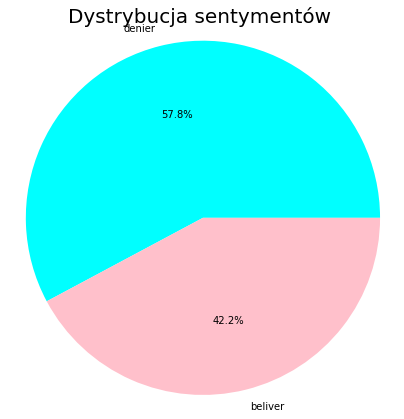

,index,sentiments
0,denier,6697
1,beliver,4887


In [130]:
emotion = {0: "denier",
           1: "beliver"}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"], labels = df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
plt.title("Dystrybucja sentymentów ", fontsize=20)
plt.show()
df_pie

In [146]:
def get_sentiments(x, sent_dict):
    total = 0
    count = 0
    test = x["cleaned_tweet"].split()
    #print(test)
    for t in test:
        #print(t)
        if words_dict.get(t):
            total += int(sent_dict.get(t))
        count+=1
    avg = total/count
    sentiment = 1 if avg > 0.15 else 0
    return sentiment

In [147]:
words_dict = dict(zip(words.words, words.cluster_value))

In [148]:
data = data[data["cleaned_tweet"]!=""]

In [149]:
data["sentiment"] = data.apply(get_sentiments, args=(words_dict,), axis=1)

In [150]:
data["sentiment"].value_counts()

1    23490
0     3812
Name: sentiment, dtype: int64

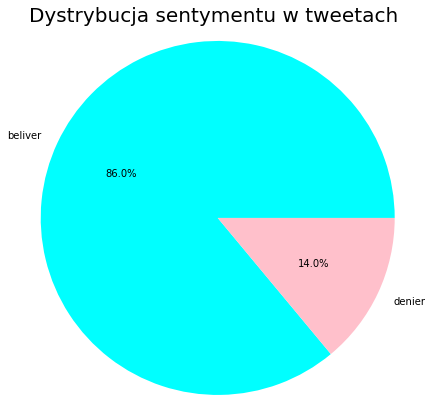

,index,sentiments_val
0,beliver,23490
1,denier,3812


In [151]:
emotion = {0: "denier",
           1: "beliver"}

data["sentiments_val"] = data["sentiment"].map(emotion)
df_pie = data["sentiments_val"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink"]
plt.pie(df_pie["sentiments_val"],labels= df_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("Dystrybucja sentymentu w tweetach ", fontsize=20)
#plt.savefig("images/Sentiment_Distribution.png")
plt.show()
df_pie

In [152]:
data.to_csv('/content/drive/MyDrive/ZUM/tweets_tagged.csv')